In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import ode
from scipy.interpolate import UnivariateSpline
import scipy
import python.songy as songy
import python.GRkernels as GRkernels

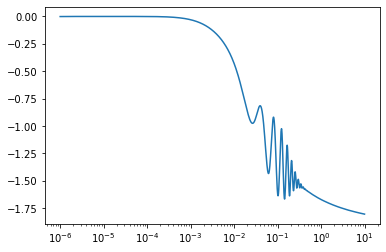

In [2]:
from classy import Class
cosmo = Class()
cosmo.set({
        'output':'dTk',
        'h':0.6777,
'T_cmb':2.7255,
'omega_b':0.022161,
'omega_cdm':0.11889,
'N_eff':3.04,
'Omega_k':0.,
'reio_parametrization':'reio_none',
#'tau_reio':0.0952,
'k_pivot':0.05,
'A_s':2.2138e-9,
'n_s':0.9611,
'YHe':0.2477055,
    'P_k_max_1/Mpc':20.0,
    'k_per_decade_for_pk':10.,
  'k_per_decade_for_bao':300.,
    'z_pk':'0.0,100.0',
    'gauge':'Synchronous'})
cosmo.compute()




def spllogder(k,z=0):
    tks = cosmo.get_transfer(z)
    #print tks.viewkeys()
    kh = tks['k (h/Mpc)']
    omega_cdm = 0.11889
    omega_b = 0.022161
    cdm_frac = omega_cdm/(omega_cdm+omega_b)
    b_frac = omega_b/(omega_cdm+omega_b)
    
    #cdmtk = cdm_frac*tks['d_cdm']+b_frac*tks['d_b']
    phitk = tks['phi']
    cdmtk = tks['d_cdm']
    h = cosmo.h()
    spldelta = scipy.interpolate.InterpolatedUnivariateSpline(kh*h,cdmtk)
    spldeltader = spldelta.derivative()
    splphi = scipy.interpolate.InterpolatedUnivariateSpline(kh*h,phitk)
    splphider = splphi.derivative()
    return k/spldelta(k)*spldeltader(k)-2.0
#    return k/splphi(k)*splphider(k)

k = np.logspace(-6,1,4000)
y1 = spllogder(k)
plt.semilogx(k,y1)


In [3]:
import os
import shutil
import subprocess
import random
import time
def run_SONG(k1,k2,k3,zvec,highacc=False):
    k1vec = list(k1)
    k2vec = list(k2)
    k3vec = list(k3)
    kvecs = [k1vec,k2vec,k3vec]
    
    if highacc:
        prefile = 'pre/kout3.pre'
    else:
        prefile = 'pre/kout2.pre'

    ininame = 'ini/tmp'+str(random.randint(100000,999999))+'.ini'
    
    with open('ini/kouttemplate.ini','r') as f:
        inilines = f.readlines()
    
    for i in range(3):
        kvec = kvecs[i]
        kvecstr = ''
        for k in kvec:
            kvecstr=kvecstr+"{:g}".format(k)+', '
        kstring = 'k'+str(i+1)+'_out = '+ kvecstr[0:-2] + "\n"
        inilines.append(kstring)
    #Set z output values:
    inilines.append('z_out='+str(zvec).strip('[]')+ "\n")
    with open(ininame, "w") as f:
        f.writelines(inilines)
    
    print(ininame)
    p = subprocess.Popen(('./song', ininame,prefile),stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    p.wait()
    output, err = p.communicate()
    if p.returncode!=0:
        print(output)
    else:
        os.remove(ininame)
    return

In [4]:
def get_SONG(zidx,baryons=False,totalmatter=False):
    omega_cdm = 0.11889
    omega_b = 0.022161
    cdm_frac = omega_cdm/(omega_cdm+omega_b)
    b_frac = omega_b/(omega_cdm+omega_b)
    filename = 'output_auto/sources_song_z'+"{:03d}".format(zidx)+'.dat'
    data = songy.FixedTauFile(filename)
    #Construct the kernel:
    fullsource = data.get_source('delta_cdm')
    delta1st = data.first_order_sources['delta_cdm']
    if baryons or totalmatter:
        fullsource_b = data.get_source('delta_b')
        delta1st_b = data.first_order_sources['delta_b']
    if totalmatter:
        delta1st_tot = cdm_frac*delta1st+b_frac*delta1st_b
        for index_k1 in range(len(data.k1)):
            for index_k2 in range(index_k1+1):
                idx = data.flatidx[index_k1,index_k2]
                fullsource[idx] = (cdm_frac*fullsource[idx]+b_frac*fullsource_b[idx])/(
                    delta1st_tot[index_k1]*delta1st_tot[index_k2])
    else:
        for index_k1 in range(len(data.k1)):
            for index_k2 in range(index_k1+1):
                idx = data.flatidx[index_k1,index_k2]
                fullsource[idx] = fullsource[idx]/(delta1st[index_k1]*delta1st[index_k2])
    if baryons:
        for index_k1 in range(len(data.k1)):
            for index_k2 in range(index_k1+1):
                idx = data.flatidx[index_k1,index_k2]
                fullsource_b[idx] = fullsource_b[idx]/(delta1st_b[index_k1]*delta1st_b[index_k2])
    Bsqueezed = []
    B_baryons = []
    K1 = []
    K2 = []
    K3 = []
    for index_k1 in range(len(data.k1)):
        for index_k2 in range(index_k1+1):
            idx = data.flatidx[index_k1,index_k2]
            k3tmp = data.k3[idx]
            if len(k3tmp)==0:
                continue
            elif len(k3tmp)>1:
                print('Should not happen!', len(k3tmp))
                continue
            else:
                K1.append(data.k1[index_k1])
                K2.append(data.k1[index_k2])
                index_k3 = 0
                K3.append(k3tmp[index_k3])
                Bsqueezed.append(fullsource[idx][index_k3])
                if baryons:
                    B_baryons.append(fullsource_b[idx][index_k3])
    if baryons:
        return np.array(K1), np.array(K2), np.array(K3), np.array(Bsqueezed), data, np.array(B_baryons)
    else:
        return np.array(K1), np.array(K2), np.array(K3), np.array(Bsqueezed), data
    

ini/tmp250033.ini
ini/tmp742343.ini
ini/tmp987858.ini


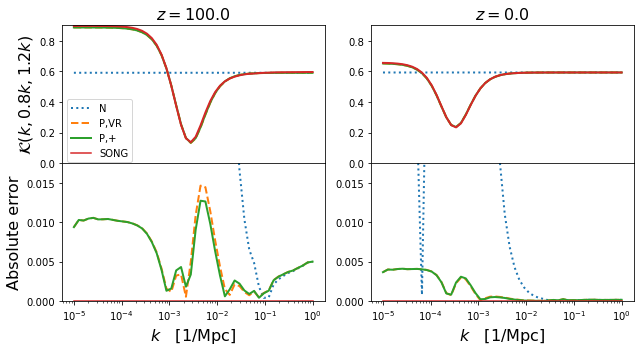

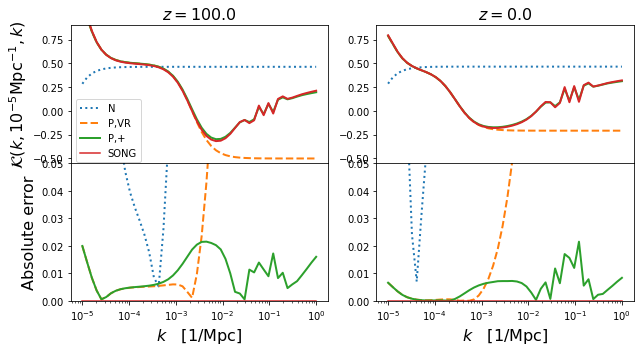

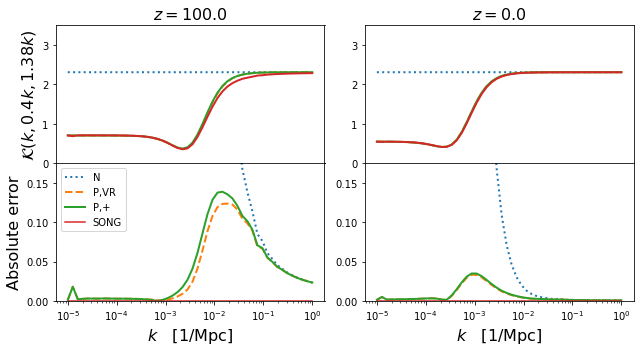

In [5]:
zvec = [100.0, 0.0]
mydict = {}
#mydict['equilateral'] = {'ylim0':[0,0.9],'ylim1':[1e-5,5],'k2string':'0.8k','k3string':'1.2k','leg_anchor':(0.0, 1.6)}
#mydict['squeezed'] = {'ylim0':[-0.55,0.9],'ylim1':[1e-4,15],'k2string':'10^{-5}','k3string':'k','leg_anchor':(0.0, 1.6)}
#mydict['flat'] = {'ylim0':[0.0,3.5],'ylim1':[1e-4,0.9],'k2string':'0.4k','k3string':'1.38k','leg_anchor':(0.0, 2.0)}

mydict['equilateral'] = {'ylim0':[0,0.9],'ylim1':[0,0.0175],'k2string':'0.8k','k3string':'1.2k','leg_anchor':(0.0, 1.5)}
mydict['squeezed'] = {'ylim0':[-0.55,0.9],'ylim1':[0,0.05],'k2string':'10^{-5}\mathrm{Mpc}^{-1}','k3string':'k','leg_anchor':(0.0, 1.5)}
mydict['flat'] = {'ylim0':[0.0,3.5],'ylim1':[0,0.175],'k2string':'0.4k','k3string':'1.38k','leg_anchor':(0.0, 1.0)}


N=50
k1 = np.logspace(-5,0,N)
for config in mydict.keys():
    customise = mydict[config]
    f, axes = plt.subplots(2, len(zvec),figsize=(9,5),sharex=True)
    if config=='squeezedk1k2':
        k2 = k1
        k3 = np.ones(k1.shape)*1e-5
    elif config=='squeezed':
        k2 = np.ones(k1.shape)*1e-5
        k3 = k1
    elif config=='equilateral':
        k2fact = 0.8
        k3fact = 1.2
        k2 = k2fact*k1
        k3 = k3fact*k1
    elif config=='flat':
        k2fact = 0.4
        k3fact = 1.38
        k2 = k2fact*k1
        k3 = k3fact*k1
    run_SONG(k1,k2,k3,zvec,highacc=False)
    for zidx in range(len(zvec)):
        K1, K2, K3, Bsqueezed, data = get_SONG(zidx,totalmatter=False)
        a = data.a
        Hc = a*data.H
        #Test if the configurations are OK
        if max(abs(1.0-k1/K1))>1e-4:
            print('K1=k1 test failed for config '+config)
            print(k1[-1],K1[-1])
        if max(abs(1.0-k2/K2))>1e-4:
            print('K2=k2 test failed for config '+config)
        if max(abs(1.0-k3/K3))>1e-4:
            print('K3=k3 test failed for config '+config)
       
        BsqueezedFSZ = GRkernels.kernel_FSZ(K1,K2,K3,Hc)
        BsqueezedRV = GRkernels.kernel_RV(K1,K2,K3,Hc,a)
        logder = spllogder(K3,z=zvec[zidx])
        #BsqueezedFSZmod = GRkernels.kernel_FSZ_mod(K1,K2,K3,Hc,logder)
        BsqueezedRVmod = GRkernels.kernel_RV_mod(K1,K2,K3,Hc,a,logder)
        BsqueezedN = GRkernels.kernel_N(K1,K2,K3,a)
        
        Banallist = [BsqueezedN,BsqueezedRV,BsqueezedRVmod]
        lslist = [':','--','-','-.']
        lw = 2
        fs = 16
        for j in range(len(Banallist)):
            Banal = Banallist[j]
            ls = lslist[j]
            axes[0][zidx].semilogx(K1,Banal,lw=lw,ls=ls)     
#            axes[1][zidx].semilogx(K1,np.abs(Banal-Bsqueezed),lw=lw,ls=ls)
            
            Err = Banal-Bsqueezed
            RelErr = np.abs(Err/Bsqueezed)
            axes[1][zidx].semilogx(K1,np.abs(Err),lw=lw,ls=ls)
        axes[0][zidx].semilogx(K1,Bsqueezed,lw=lw)
        axes[1][zidx].semilogx(K1,1e-16*np.ones(K1.shape))
        axes[1][zidx].semilogx(K1,-np.ones(K1.shape))
        
        axes[0][zidx].set_ylim(customise['ylim0'])
        axes[1][zidx].set_ylim(customise['ylim1'])
        axes[1][zidx].set_xlabel(r'$k\quad [1/\mathrm{Mpc}]$',fontsize=fs)
        axes[0][zidx].set_title(r'$z = '+str(zvec[zidx])+'$',fontsize=fs)

    axes[0][0].set_ylabel(r'$\mathcal{K}(k,'+customise['k2string']+','+customise['k3string']+')$',fontsize=fs)
    axes[1][0].set_ylabel(r'Absolute error',fontsize=fs)
    f.tight_layout()
    f.subplots_adjust(hspace = 0.0)
    L=axes[1][0].legend(['N','P,VR','P,+','SONG'],loc='upper left',bbox_to_anchor=customise['leg_anchor'])
    f.savefig('simple-'+config+'z.pdf',bbox_inches='tight')

ini/tmp409852.ini


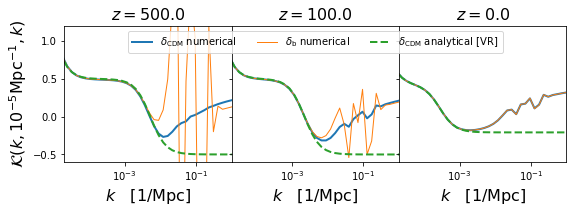

In [6]:
zvec = [500.0, 100.0, 0.0]
f, axes = plt.subplots(1,len(zvec),figsize=(9,2.5),sharex=True,sharey=True)
N=40
k1 = np.logspace(-5,0,N)
k2 = np.ones(k1.shape)*1e-5
k3 = k1
run_SONG(k1,k2,k3,zvec)
for zidx in range(len(zvec)):
    K1, K2, K3, Bsqueezed, data, B_baryons = get_SONG(zidx,True)
    a = data.a
    Hc = a*data.H
    #Test if the configurations are OK
    if max(abs(1.0-k1/K1))>1e-4:
        print('K1=k1 test failed for config '+config)
    if max(abs(1.0-k2/K2))>1e-4:
        print('K2=k2 test failed for config '+config)
    if max(abs(1.0-k3/K3))>1e-4:
        print('K3=k3 test failed for config '+config)
    BsqueezedRV = GRkernels.kernel_RV(K1,K2,K3,Hc,a)
    lw=2
    fs=16
    axes[zidx].semilogx(K1,Bsqueezed,lw=lw,ls='-') 
    axes[zidx].semilogx(K1,B_baryons,lw=1,ls='-') 
    axes[zidx].semilogx(K1,BsqueezedRV,lw=lw,ls='--') 
    axes[zidx].set_xlabel(r'$k\quad [1/\mathrm{Mpc}]$',fontsize=fs)
    axes[zidx].set_title(r'$z = '+str(zvec[zidx])+'$',fontsize=fs)
axes[0].set_xlim([2e-5,1.0])
axes[0].set_ylim([-0.6,1.2])
axes[0].set_ylabel(r'$\mathcal{K}(k,10^{-5}\mathrm{Mpc}^{-1},k)$',fontsize=fs)
axes[2].legend(['$\delta_\mathrm{CDM}$ numerical', '$\delta_\mathrm{b}$ numerical','$\delta_\mathrm{CDM}$ analytical [VR]'],
               loc='upper center',ncol=3,bbox_to_anchor=(-0.5,1.0))

f.subplots_adjust(wspace = 0.0)
f.savefig('simple-bao-squeezed.pdf',bbox_inches='tight')

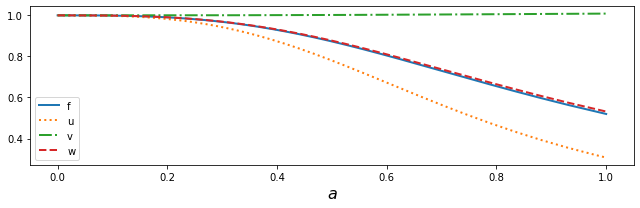

In [7]:
f = plt.figure(figsize=(9,3.0))
lw = 2
fs = 16
plt.plot(GRkernels.avec,GRkernels.fvec,lw=lw)
plt.plot(GRkernels.avec,GRkernels.uvec,lw=lw,ls=':')
plt.plot(GRkernels.avec,GRkernels.vvec,lw=lw,ls='-.')
plt.plot(GRkernels.avec,GRkernels.wvec,lw=lw,ls='--')

#plt.legend([r"$f = a D'(a)/D$",
#            r"$u = \left(1+\Omega_\Lambda/\Omega_M a^3\right)^{-1}$",
#            r"$v = 7F/(3D^2)$",
#            r"$w = 7aF'(a)/(6D^2)$"],loc='lower left')
plt.legend(['f','u','v','w'],loc='lower left')
plt.xlabel('$a$',fontsize=fs)
plt.tight_layout()
plt.savefig('simple-fuvw.pdf',bbox_inches='tight')

In [8]:
def SONGinterpolate(K2interp,K3interp,data,somesource):
    import scipy
    #K2interp = K2R
    #K3interp = K3R
    T = []
    K1vec = []
    for index_k1 in range(len(data.k1)):
        k1data = data.k1[index_k1]
        K2 = []
        K3 = []
        S = []
        for index_k2 in range(index_k1+1):
            idx = data.flatidx[index_k1,index_k2]
            for k3idx in range(len(data.k3[idx])):
                K2.append(data.k1[index_k2])
                K3.append(data.k3[idx][k3idx])
                S.append(somesource[idx][k3idx])
        K2 = np.array(K2)
        K3 = np.array(K3)
        S = np.array(S)
        if len(np.unique(K2))>1:
            T.append(scipy.interpolate.griddata((K2/k1data,K3/k1data),S,(K2interp,K3interp)))
            K1vec.append(k1data)
    T = np.array(T)
    LastInterp = scipy.interpolate.interp1d(K1vec,T,axis=0,kind='linear')
    return LastInterp

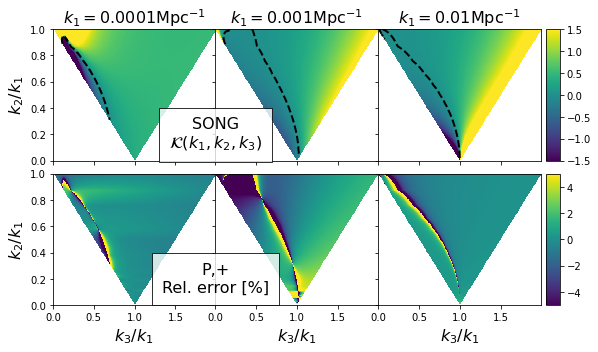

In [9]:
import scipy

Nk1 = 3
f, ax = plt.subplots(2, Nk1,figsize=(9,5),sharex=True,sharey=True)


zidx = 0
filename = 'output/sources_song_z'+"{:03d}".format(zidx)+'.dat'
data = songy.FixedTauFile(filename)
fs=16
lw=2
#Construct the kernel:
a = data.a
Hc = a*data.H
totalmatter=True
omega_cdm = 0.11889
omega_b = 0.022161
cdm_frac = omega_cdm/(omega_cdm+omega_b)
b_frac = omega_b/(omega_cdm+omega_b)
if totalmatter:
    fullsource = data.get_source('delta_cdm')
    fullsource_b = data.get_source('delta_b')
    delta1st = cdm_frac*data.first_order_sources['delta_cdm']+b_frac*data.first_order_sources['delta_b']
else:    
    fullsource = data.get_source('delta_cdm')
    delta1st = data.first_order_sources['delta_cdm']

RVmod = [None]*len(fullsource)
for index_k1 in range(len(data.k1)):
    for index_k2 in range(index_k1+1):
        idx = data.flatidx[index_k1,index_k2]
        if totalmatter:
            fullsource[idx] = (cdm_frac*fullsource[idx]+b_frac*fullsource_b[idx])/(delta1st[index_k1]*delta1st[index_k2])
        else:
            fullsource[idx] = fullsource[idx]/(delta1st[index_k1]*delta1st[index_k2])
        k3 = data.k3[idx]
        RVmod[idx] = GRkernels.kernel_RV_mod(data.k1[index_k1],data.k1[index_k2],data.k3[idx],Hc,a,spllogder(data.k3[idx]))
        
K3R,K2R = np.meshgrid(np.linspace(0,2,500),np.linspace(0,1,200))
SONGinterp = SONGinterpolate(K2R,K3R,data,fullsource)
RVmodinterp = SONGinterpolate(K2R,K3R,data,RVmod)

#k1select = np.logspace(-4,0,Nk1)
#k1select = [0.0001+i*0.0002 for i in range(Nk1)]
#k1select = [0.0001+i*0.0001 for i in range(Nk1)]
k1select = [1e-4,1e-3,1e-2]
for nk1 in range(Nk1):
    k1 = k1select[nk1]
    BS = SONGinterp(k1)
    ErrPct = 100.0*(RVmodinterp(k1)/BS-1)
    cont1 = ax[0,nk1].imshow(BS,aspect='auto',origin='lower',interpolation='none',vmin=-1.5,vmax=1.5,extent=[0,2.0,0,1])
    cont2 = ax[1,nk1].imshow(ErrPct,aspect='auto',origin='lower',interpolation='none',vmin=-5,vmax=5,extent=[0,2.0,0,1])
    C = ax[0,nk1].contour(K3R,K2R,BS,levels=[0.0],linewidths=2,linestyles=['--'],colors='k')
    ax[0,nk1].set_title(r'$k_1 = '+"{:g}".format(k1)+'\mathrm{Mpc}^{-1}$',fontsize=fs)
    ax[1,nk1].set_xlabel(r'$k_3/k_1$',fontsize=fs)
    ax[0,0].set_xlim([0,1.99])

ax[0,1].text(0.0, 0.1, "SONG\n$\mathcal{K}(k_1,k_2,k_3)$", bbox=dict(facecolor='white', alpha=0.8,pad=10.0),fontsize=fs,ha='center',fontweight='normal')
ax[1,1].text(0.0, 0.1, "P,+\nRel. error [%]", bbox=dict(facecolor='white', alpha=0.8,pad=10.0),fontsize=fs,ha='center',fontweight='normal')
for j in range(2):
    ax[j,0].set_ylabel(r'$k_2/k_1$',fontsize=fs)
f.tight_layout()
f.subplots_adjust(hspace = 0.1,wspace=0.0)
f.colorbar(cont1,ax=[element for element in ax[0]],pad=0.01,aspect=10)
f.colorbar(cont2,ax=[element for element in ax[1]],pad=0.01,aspect=10)


f.savefig('simple-fullebispTM.pdf',bbox_inches='tight')